In [1]:
from arcgis.gis import GIS
import arcgis.network as network
from arcgis.features import FeatureLayer, Feature, FeatureSet, use_proximity, FeatureCollection
import pandas as pd
import time
import datetime as dt

# The environment settings library
from decouple import config

In [2]:
# Connect to the GIS
gis = GIS(url='https://arcgis.com', username=config('GIS_USERNAME'), password=config('GIS_PASSWORD'))

<Item title:"zwe_vaccination_centers_" type:Feature Layer Collection owner:kumbirai_matingo>
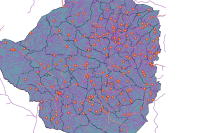

In [3]:
vaccination_resources = gis.content.get("f464c7f46aea483694cf2ed13e6471f4")
display(vaccination_resources)

In [4]:
vac_centers = vaccination_resources.layers[0]
vac_centers

<FeatureLayer url:"https://services8.arcgis.com/oTalEaSXAuyNT7xf/arcgis/rest/services/zwe_vaccination_centers_/FeatureServer/0">

## Geocode the user location

In [5]:
from arcgis.geocoding import geocode
my_location = input("What is your current location?")

What is your current location?Tsholotsho


In [6]:
results = geocode(my_location)
# query the first matched result
coordinates = results[0]['location']
coordinates

{'x': 27.750630000000058, 'y': -19.76296999999994}

In [7]:
x_coordinate = coordinates['x']
y_coordinate = coordinates['y']

## Create Incidence Layer

In [8]:
incidents_json = {
                    "features": [{"attributes": {"CurbApproach": 0,
                                                 "ID": "F100086",
                                                 "Name": "User Location"},
                                  "geometry": {"x": x_coordinate, "y": y_coordinate}}
                                 ],
                    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
                    "geometryType": "esriGeometryPoint",
                    "fields" : [
                        {"name" : "ID", "type" : "esriFieldTypeString", "alias" : "ID", "length" : "50"},
                        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
                        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"}
                    ]
                }
incidents = FeatureSet.from_dict(incidents_json)

## Visualize on Map

In [9]:
map1 = gis.map('Zimbabwe', zoomlevel=6)
map1

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
user_location = {"type":"esriPMS",
                           "url":"https://image.flaticon.com/icons/png/512/10/10966.png", #User symbol from Flaticon
                           "contentType": "image/png", "width":20, "height":20}

# centers_for_vac = {"type": "esriPMS",
#                                "url":"https://image.flaticon.com/icons/png/512/3627/3627356.png", #Vac Symbol from Flaticon
#                                "contentType": "image/png", "width":20, "height":20}

map1.draw(incidents, symbol=user_location)
# map1.draw(vac_centers, symbol=centers_for_vac)

## Find Closest Facilities

In [11]:
%%time
current_time = dt.datetime.now()  
result1 = network.analysis.find_closest_facilities(incidents=incidents, facilities=vac_centers, 
                                                   cutoff=25, time_of_day=current_time, 
                                                   number_of_facilities_to_find=1,
                                                   save_output_network_analysis_layer=True,
                                                   gis=gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Avoid Unpaved Roads").


Wall time: 43.1 s


## Was the tool executed successfully?

In [12]:
print("Is the tool executed successfully?", result1.solve_succeeded)

Is the tool executed successfully? True


In [13]:
result1

ToolOutput(output_routes=<FeatureSet> 1 features, output_directions=<FeatureSet> 0 features, solve_succeeded=True, output_closest_facilities=<FeatureSet> 1 features, output_network_analysis_layer={"url": "https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/closestfacility_gpserver/j5fdb37a4d5014745bc2be7675b8b27ad/scratch/_ags_gpnad3c467133131425d9d89a5271d723eed.lyr"}, output_route_data=None, output_incidents=<FeatureSet> 1 features, output_facilities=<FeatureSet> 211 features, output_result_file=None, output_network_analysis_layer_package={"url": "https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/closestfacility_gpserver/j5fdb37a4d5014745bc2be7675b8b27ad/scratch/_ags_gpnad3c467133131425d9d89a5271d723eed.lpkx"}, output_direction_points=None, output_direction_lines=None)

In [14]:
result1.output_network_analysis_layer.url

'https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/closestfacility_gpserver/j5fdb37a4d5014745bc2be7675b8b27ad/scratch/_ags_gpnad3c467133131425d9d89a5271d723eed.lyr'

## Create Dataframe with Results

In [15]:
""" to create tables with valid information
"""
df4 = result1.output_routes.sdf
start_times = pd.to_datetime(df4["StartTime"], unit="ms")
end_times = pd.to_datetime(df4["EndTime"], unit="ms")
df4["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df4["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
# df4[["Name", "StartTime", "EndTime", "IncidentID", "Total_Kilometers", "Total_Minutes"]]
df4.head()

,ObjectID,FacilityRank,Name,IncidentCurbApproach,FacilityCurbApproach,StartTime,EndTime,StartTimeUTC,EndTimeUTC,FacilityID,IncidentID,Total_Miles,Total_Kilometers,Total_Minutes,FacilityOID,IncidentOID,Shape_Length,SHAPE
0,1,1,User Location - Location 55,1,2,09:26:00,09:29:47,2021-08-18 07:26:00.516999936,2021-08-18 07:29:47.586999808,1141,F100086,1.036615,1.668273,3.784496,55,1,0.015381,"{""paths"": [[[27.75063254300005, -19.7629752009..."


In [16]:
print(df4['SHAPE'])

0    {"paths": [[[27.75063254300005, -19.7629752009...
Name: SHAPE, dtype: geometry


## Visualize Results

In [17]:
map2 = gis.map(my_location, zoomlevel=10)
map2

MapView(layout=Layout(height='400px', width='100%'))

In [18]:
# draw the facilities and incidents on this map
map2.draw(incidents, symbol=user_location, attributes={"title":"Incident Location"})

In [19]:
# draw the routes on the map
map2.add_layer(result1.output_routes)

## Create Variables from Data

In [20]:
start_time = df4['StartTime'][0]
end_time = df4['EndTime'][0]
distance = df4['Total_Kilometers'][0]
total_time = round(df4['Total_Minutes'][0], 2)

In [21]:
print(f"Based on your location it will take you {total_time} minutes to travel to the nearest Vaccination Center which is {distance} kilometers. You estimated arrival time is {end_time}")

Based on your location it will take you 3.78 minutes to travel to the nearest Vaccination Center which is 1.6682732175993054 kilometers. You estimated arrival time is 09:29:47
